# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Lending Club Project


**Harvard University**<br/>
**Fall 2018**<br/>

<hr style="height:2pt">



In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [3]:
# # --------------------------
# # New packages to install if needed for mapping
# # --------------------------

# # Install plotly 
# !pip install plotly

# # Alternative is the geopandas library (which also needs descartes to work)
# !pip install git+git://github.com/geopandas/geopandas.git
# !pip install descartes

In [4]:
# --------------------------
# Load general numerical packages
# --------------------------
import numpy as np
import pandas as pd
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# Load sklearn
# --------------------------
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV

from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics as metrics

from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

# --------------------------
# Plotting
# --------------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
sns.set()
import matplotlib.style
matplotlib.style.use('seaborn-whitegrid')
sns.set_style("white")
from IPython.display import display

# --------------------------
# Other packages
# --------------------------
import statsmodels.api as sm
from statsmodels.api import OLS
from IPython.display import display

# --------------------------
# Mapping
# --------------------------
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

import geopandas as gpd

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ModuleNotFoundError: No module named 'geopandas'

In [ ]:
# increase display options to display all columns and more rows.
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 150

<hr style="height:2pt">

<div class='theme'> Overview </div>

### This notebook contains the following sections:
* **Part 1**: Preparing the data: cleaning, resampling to achieve balanced classes, scaling etc
* **Part 2**: Developing maps to display the data
* **Part 3**: Exploring model performance metrics
* **Part 4**: Model tuning
* **Part 5**: Model comparisons


<div class='exercise'><b> Part 1: Preparing the data </b></div>

This notebook uses the cleaned CSV data file `data_cleaned_2016_2017.csv` downloaded from https://drive.google.com/open?id=1LCk-dDFC7O_6ek1i0IIGqE07Rq-kf1Xz. <br><br>

### Pre-processing the clean dataset

The cleaned dataset still needs some pre-processing in order to make it ready for modelling. This includes:

* Removing several more columns that are not informative, for example where they duplicate other information or only have a single value
* Drop the last digits of the zip code
* Recoding some ordinal variables into numerical scales
* Recoding some categorical variables into dummy variables

In [88]:
# read in the 2016-2017 data set
original_df = pd.read_csv('../../../data/data_cleaned_2016_2017.csv', low_memory = False)


In [89]:
# --------------------------
# Function to finalise data preparation
# --------------------------
def data_prep(df):
    '''Returns a cleaned up dataframe as basis for the EDA analysis
    Input:
        df: the pd.DataFrame object
    Returns:
        clean_df: pd.DataFrame object
    '''
    clean_df = df.copy()
    
    # --------------------------
    # Definitions
    # --------------------------
    cols_to_remove = ['mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                      'mo_sin_rcnt_tl', 'funded_amnt', 'funded_amnt_inv', 'num_sats', 
                   'application_type', 'num_actv_rev_tl', 'pymnt_plan']
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 'addr_state']
    prefixes = ['home', 'verify', 'purp', 'state']
    
    # --------------------------
    # Drop additional uninformative columns
    # --------------------------
    clean_df = clean_df.drop(columns=cols_to_remove)
    
    # --------------------------
    # Strip xx from zip code
    # --------------------------
    clean_df["zip_code"] = [x.strip("xx") for x in clean_df["zip_code"].astype(str)]
    clean_df["zip_code"] = clean_df["zip_code"].astype(int)
    
    # --------------------------
    # Exclude zip code from set of predictors for analysis
    # --------------------------
    # to be added back in later for checking discrimination...
    clean_df = clean_df.drop(columns='zip_code')

    # --------------------------
    # Ordinal columns are encoded as numerical values
    # --------------------------
    clean_df["grade"].replace({"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}, inplace = True)
    clean_df["sub_grade"].replace({"A1": 1, "A2": 2, "A3": 3, "A4": 4, "A5": 5,
                                "B1": 6, "B2": 7, "B3": 8, "B4": 9, "B5": 10,
                                "C1": 11, "C2": 12, "C3": 13, "C4": 14, "C5": 15,
                                "D1": 16, "D2": 17, "D3": 18, "D4": 19, "D5": 20,
                                "E1": 21, "E2": 22, "E3": 23, "E4": 24, "E5": 25,
                                "F1": 26, "F2": 27, "F3": 28, "F4": 29, "F5": 30,
                                "G1": 31, "G2": 32, "G3": 33, "G4": 34, "G5": 35}, inplace = True)

    # --------------------------
    # Nominal columns are encoded via hot encoding by adding more columns
    # --------------------------
    clean_df = pd.get_dummies(clean_df, columns=nominal_columns, prefix=prefixes, drop_first=True)

    return clean_df

In [90]:
df_all = data_prep(original_df)

In [91]:
df_all.shape

(334109, 140)

### Resample to achieve balanced classes

Since we have imbalanced classes that can cause misleading assessment of model performance, we resample the classes here. We also take the opportunity to reduce the dataset size in the initial stages, so that different model specifications can be tested faster.

In [92]:
# Check balance of target values - it is unbalanced
df_all["loan_status"].value_counts().to_frame()

,loan_status
Fully Paid,255116
Charged Off,78993


In [93]:
# --------------------------
# Function to downsample and create balanced classes
# --------------------------

def balance_classes(df, n_samples, random_state = 1):
    # --------------------------
    # Define majority and minority classes
    # --------------------------
    df_majority = df[df["loan_status"] == "Fully Paid"]
    df_minority = df[df["loan_status"] == "Charged Off"]
    
    # --------------------------
    # Downsample majority and minority classes
    # --------------------------
    df_majority_downsampled = resample(df_majority, 
                                     replace = False,    # sample without replacement
                                     n_samples = n_samples,   
                                     random_state = random_state) # set random seed for reproducability

    df_minority_downsampled = resample(df_minority, 
                                     replace = False,
                                     n_samples = n_samples,   
                                     random_state = random_state) 

    # --------------------------
    # Recombine
    # --------------------------
    df_downsampled = pd.concat([df_majority_downsampled, df_minority_downsampled])

    return df_downsampled

In [94]:
# Define how many samples of each we want
n_samples = 5000 # Reduce number so that models run faster

df = balance_classes(df_all, n_samples)

In [95]:
df["loan_status"].value_counts().to_frame()

,loan_status
Charged Off,5000
Fully Paid,5000


### Scale the data and generate train/test splits

Since we will be using models that are sensitive to scale, we need to scale the data. This is done in a function for reproducability.

<font color = "red">
    
NB: 
* Added stratify argument to train test split to ensure we still have 50:50 balance
* Extracted interest rates from the test set for use in calculating returns



In [96]:
# Function to generate train test splits and scale the data
def get_train_test(df, test_size = 0.2, random_state = 1):
    nonbinary_columns = ['loan_amnt','int_rate','installment','grade','sub_grade','emp_length',
                         'annual_inc','issue_d','dti', 'delinq_2yrs','earliest_cr_line','inq_last_6mths', 
                         'open_acc','pub_rec','revol_bal','revol_util','total_acc', 'annual_inc_joint',
                         'dti_joint','acc_now_delinq','open_acc_6m','open_act_il', 'open_il_12m',
                         'open_il_24m', 'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc',
                         'all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths',
                         'avg_cur_bal','bc_open_to_buy','bc_util','chargeoff_within_12_mths',
                         'delinq_amnt','mort_acc','num_accts_ever_120_pd', 'num_actv_bc_tl',
                         'num_bc_sats','num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
                         'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
                         'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                         'tax_liens', 'revol_bal_joint', 'sec_app_mort_acc', 'sec_app_revol_util',
                         'sec_app_mths_since_last_major_derog']
    result = df.copy()
    
    # --------------------------
    # Train test split
    # --------------------------
    
    data_train, data_test = train_test_split(result, 
                                             test_size = test_size, 
                                             random_state = random_state,
                                            stratify = result.loan_status)
    X_train = data_train.iloc[:, data_train.columns != 'loan_status']
    y_train = data_train['loan_status']
    X_test = data_test.iloc[:, data_test.columns != 'loan_status']
    y_test = data_test['loan_status']
    
    # --------------------------
    # Extract unscaled interest rate for use in calculating returns
    # --------------------------
    interest_rates = X_test["int_rate"].copy()
    
    # --------------------------
    # Scaling: Incorporate here so that we can use it consistently across all models
    # --------------------------
    
    scaler = StandardScaler()
    X_train[nonbinary_columns] = scaler.fit_transform(X_train[nonbinary_columns])
    X_test[nonbinary_columns] = scaler.transform(X_test[nonbinary_columns])
    
    
    # --------------------------
    # Recode loan status
    # --------------------------
  
    y_train = y_train.replace({'Fully Paid': 1, 'Charged Off': 0})
    y_test = y_test.replace({'Fully Paid': 1, 'Charged Off': 0})
    
    return X_train, y_train, X_test, y_test, interest_rates

In [97]:
# Create scaled train and test sets, plus extract interest rates on the test set
X_train, y_train, X_test, y_test, interest_rates = get_train_test(df)


In [98]:
y_train.value_counts().to_frame()

,loan_status
1,4000
0,4000


In [99]:
# Check interest rates
interest_rates.head()

259730    18.99
230737     6.97
134972    13.67
230627     6.49
3075      13.49
Name: int_rate, dtype: float64

<div class='exercise'><b> Part 2: Mapping </b></div>

### Using maps to display the data

This may come in useful later on when presenting the results, or as part of the EDA. The maps show that there is variation of the charge-off rate across the different States, with higher rates tending to be in the Eastern States. 

Resources used:
* Some example code on how to use Geopandas http://darribas.org/gds15/content/labs/lab_03.html 
* Downloadable shape files for the US: https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip


In [100]:
# --------------------------
# Set up data to be mapped
# --------------------------
# Recode loan status
original_df["loan_status"] = original_df["loan_status"].replace({'Fully Paid': 1, 'Charged Off': 0})

# Aggregating data by State
default_rate = 1 - original_df.groupby(["addr_state"]).mean()["loan_status"]

### Plotly: interactive map

This code generates an interactive map of charge-off rates by State.

In [ ]:
# --------------------------
# Set up inputs for the map using plotly
# --------------------------
data = [ dict(
        type = 'choropleth',
        locations = default_rate.index,
        z = default_rate, 
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Default rate")
        ) ]

layout = dict(
        title = 'Average Charge off rate by State',
        geo = dict(
            scope = 'usa',
            projection = dict(type = 'albers usa' ),
            showlakes = True, 
            lakecolor = 'rgb(255, 255, 255)'),)
    

In [ ]:
# --------------------------
# Create map using plotly
# --------------------------
fig = dict(data = data, 
           layout = layout)
iplot(fig, filename = 'cloropleth-map')

### Static maps using shape files

This part uses the shape files from the US census website

In [ ]:
# --------------------------
# Create map using shape files 
# --------------------------

# Read in the shape files with geopandas
path = "../../shape_files/cb_2017_us_state_500k.shp" # census files
#path = "../../shape_files/states.shp"
states_map = gpd.read_file(path)

# Remove any states that aren't in the LendingClub data
states_map2 = states_map[states_map["STUSPS"].isin(list(original_df["addr_state"]))]

# Join the map data with the default rate
mapping_data = states_map2.join(default_rate, on = "STUSPS")
#mapping_data.head()

In [ ]:
# Plot 
fig, ax = plt.subplots(1, figsize = (20, 10))
ax = mapping_data[mapping_data['NAME'].isin(['Alaska','Hawaii']) == False].plot(axes = ax, 
                       column = "loan_status",
                       cmap = "Blues", legend = True)

ax.axis('off')
#fig.tight_layout()
ax.set_title('Average charge off rate per State', fontdict = {'fontsize': '20', 'fontweight' : '3'});

<div class='exercise'><b> Part 3: Model performance metrics </b></div>

In this section, we develop a wrapper function that will allow for multiple models to be trained and tested according to different performance metrics

### Overview of performance metrics used

Since the cost of a false positive is relatively high, this needs to be accounted for when choosing the best model, while still aiming for a good overall performance. For the purposes of this project, we consider several metrics:

* __Precision__ = True positive / (True positive + False positive). Precision represents how precise the model is in predicting positive values, and is a good metric to use when the cost of false positives is high, as in our case. 
* __Recall__ = True positive / (True positive + False negative). Recall represents how many of the actual positives were correctly picked up by the model. It is important to use when the cost of false negatives is high. 
* __F1 score__ = harmonic mean of precision and recall. There is typically a trade-off between precision and recall and F1 therefore seeks to create a balance between these two metrics. 
* __ROC__ = The ROC plots the true positive rate (sensitivity) against the false positive rate (1-specificity) and therefore shows the trade-offs between the two.
* __AUC__ = Area under the ROC curve. The AUC for a classifier with no power (random guessing) is 0.5. If the AUC is 0.7, it means there is 70% chance that model will be able to distinguish between positive class and negative class.


Resources used:
* Graph showing optmisation according to scoring: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
* Inspiration for use of different metrics: https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

<font color = "red">
The code below is basically reworking those two websites above.
I realised after playing with the models a bit that we probably need to use a mixture of metrics to get the best overall model, otherwise if we just use precision we trade off too much on recall.


<font color = "blue"> 
### New: Developing custom scoring metrics 




### Equal opportunity metric

Return the ratio of true positives to positive examples in the dataset

In [88]:
# --------------------------
# Create a custom scoring function that calculates Equal Opportunity
# -------------------------- 
def equal_opportunity(y_test, y_test_pred, protected_class):
    """Return the ratio of true positives to positive examples in the
        dataset, :math:`TPR = TP/P`, optionally conditioned on protected
        attributes.
        Adapted from IBM360 Research.
       
        Returns: Equal opportunity diffence between priviliged and unpriviliged group 
        (works ONLY with binary classification at this point)
    """
    protected = np.where(X_test[protected_class] == 1) # Select protected class
    not_protected = np.where(X_test[protected_class] == 0) # Select unprotected class
    
    # --------------------------
    # Calculate positives, P and true positives, TP for protected class
    # --------------------------  
    TP_protected = (y_test_pred.iloc[protected] == 1) & (y_test.iloc[protected] == 1)
    P_protected = (y_test_pred.iloc[protected] == 1)
    TPR_protected = TP_protected / P_protected
    print("TPR for protected class is", TPR_protected)
    
    # --------------------------
    # Same for un-protected class
    # --------------------------  
    TP = (y_test_pred.iloc[not_protected] == 1) & (y_test.iloc[not_protected] == 1)
    P = (y_test_pred.iloc[not_protected] == 1)
    TPR = TP / P
    print("TPR for un-protected class is", TPR)
    

In [101]:
# Develop a quick classifier to play with
test_model = LogisticRegression(penalty = "l2").fit(X_train, y_train)
y_test_pred = test_model.predict(X_test)

In [89]:
protected_class = "term" # define protected class for practice
equal_opportunity(y_test, y_test_pred, protected_class)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

### Expected return metric - Oyvind to look at this one

The code below implements a simple calculation of the expected return from each investment strategy (as defined by the classification models). It assumes that:
* $100 is invested in each loan
* The investor loses half of their investment if the loan is charged off
* The investor gains the interest on the loan, minus Lending Club's fees, if the loan is paid back

### Expected return metric - Oyvind to look at this one

The code below implements a simple calculation of the expected return from each investment strategy (as defined by the classification models). It assumes that:
* $100 is invested in each loan 
* The investor gets the money invested plus the investors share of the interest received, when the loan is fully paid
* The investor gets the given percentage of all payments done when the loan is charged off

In [5]:
# --------------------------
# Import the complete set of data files
# -------------------------- 
Q1_2017 = pd.read_csv('../../../data/LoanStats_2017Q1.csv',low_memory=False,skiprows=1)
Q2_2017 = pd.read_csv('../../../data/LoanStats_2017Q2.csv',low_memory=False,skiprows=1)
Q3_2017 = pd.read_csv('../../../data/LoanStats_2017Q3.csv',low_memory=False,skiprows=1)
Q4_2017 = pd.read_csv('../../../data/LoanStats_2017Q4.csv',low_memory=False,skiprows=1)

Q1_2016 = pd.read_csv('../../../data/LoanStats_2016Q1.csv',low_memory=False,skiprows=1)
Q2_2016 = pd.read_csv('../../../data/LoanStats_2016Q2.csv',low_memory=False,skiprows=1)
Q3_2016 = pd.read_csv('../../../data/LoanStats_2016Q3.csv',low_memory=False,skiprows=1)
Q4_2016 = pd.read_csv('../../../data/LoanStats_2016Q4.csv',low_memory=False,skiprows=1)

Year_2016_2017 = pd.concat([Q1_2017,Q2_2017,Q3_2017,Q4_2017,Q1_2016,Q2_2016,Q3_2016,Q4_2016])

In [51]:
df = Year_2016_2017.loc[Year_2016_2017['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [8]:
result = df[['loan_amnt','int_rate','loan_status','title','total_pymnt']]

In [9]:
# --------------------------
# Make adjustments to dataframe
# -------------------------- 

result['Recieved'] = result['total_pymnt'] / result['loan_amnt'] *100
result['Recieved'].astype(float)
result['Gain loss'] = (result['Recieved'] - 100)
result['int_rate'] = result['int_rate'].str[:-1].astype(float)
result['int_round'] = result['int_rate'].round(0).astype(int)

In [87]:
# --------------------------
# Find the stats for the loans that gets charged off
# The investor experience an average loss of 60 % of each loan that gets charged off
# -------------------------- 
result[result['loan_status']=='Charged Off']['Gain loss'].describe()

count    78993.000000
mean       -60.363737
std         19.905434
min       -100.000000
25%        -75.564720
50%        -62.587913
75%        -47.043714
max        117.030000
Name: Gain loss, dtype: float64

In [19]:
# --------------------------
# Calculate investors return if the investor invests $100 in each of the 334109 loans
# -------------------------- 

gb = result[['int_round', 'Gain loss']].groupby(['int_round']).sum()

Text(0.5,0,'Interest rate bracket')

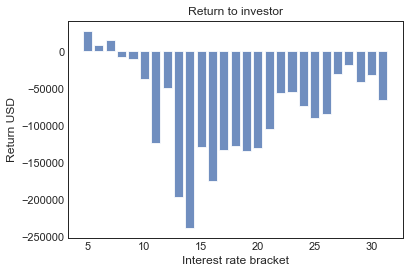

In [34]:
plt.title('Return to investor')
plt.bar(gb.index, gb['Gain loss'], align='center', alpha=0.8)
plt.ylabel('Return USD')
plt.xlabel('Interest rate bracket')

In [45]:
# --------------------------
# Calculate investors return if the investor invests $100 in 100 loans of each interest rate bracket
# -------------------------- 

dg = result.groupby('int_round')['int_round','Gain loss'].head(100)
ds = dg[['int_round', 'Gain loss']].groupby(['int_round']).sum()

Text(0.5,0,'Interest rate bracket')

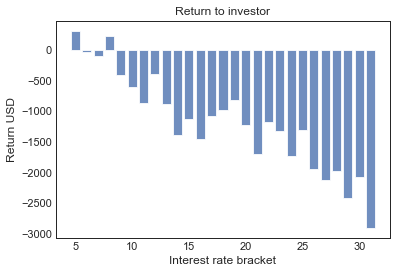

In [47]:
plt.title('Return to investor')
plt.bar(ds.index, ds['Gain loss'], align='center', alpha=0.8)
plt.ylabel('Return USD')
plt.xlabel('Interest rate bracket')

In [78]:
print("An investor that invest $100 in each of the 334109 will get a return of {:7.9} dollar on the investment,".format(gb['Gain loss'].sum()))
print("while an investor that only invest in 100 loans in each bracket will get a return of {:5.7} ".format(ds['Gain loss'].sum()))

An investor that invest $100 in each of the 334109 will get a return of -2096048.09 dollar on the investment,
while an investor that only invest in 100 loans in each bracket will get a return of -31556.22 


In [102]:
# --------------------------
# Create a custom scoring function that calculates expected return
# -------------------------- 
        
def expected_return(y_test, y_test_pred):
    # --------------------------
    # Asusmptions
    # -------------------------- 
    amount_per_loan = 100 # Assue we invest $100 in every loan
    loss_rate = 0.6 # Assume that we lose 50% of the investment for each charged off loan
    LC_rate = 1 # Lending club fees of 1%
    
    # --------------------------
    # Get index of true positivies, TP and false positives, FP
    # -------------------------- 
    TP = (y_test_pred == 1) & (y_test == 1)
    FP = (y_test_pred == 1) & (y_test == 0)
    
    # --------------------------
    # Calculate gain from loans paid back and loss for charged off loans
    # --------------------------     
    gain = sum(amount_per_loan * (interest_rates[TP].values - LC_rate)/100)
    loss =  loss_rate * amount_per_loan * sum(FP)
    net = gain - loss
    
    return net

# --------------------------
# Turn this into a custom scorer
# -------------------------- 
expected_return_score = make_scorer(expected_return, greater_is_better=True)


In [103]:
# Try it out on the logistic model... leads to a big loss. 
# Oyvind to look at this

expected_return(y_test, y_test_pred)

-14077.870000000035

In [41]:
# --------------------------
# Define scores to use
# --------------------------
scoring = {
    "AUC": "roc_auc", # Area under the curve
    "precision_score": make_scorer(precision_score),
    "recall_score": make_scorer(recall_score),
    "accuracy_score": make_scorer(accuracy_score),
    "f1_score": make_scorer(f1_score)
}

### Developing a wrapper function to optimise model hyper parameters according to a specified metric

When specifying multiple metrics, the refit parameter must be set to the metric (string) for which the best_params_ will be found and used to build the best_estimator_ on the whole dataset. 

Setting refit_score = 'AUC', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated AUC score. Other metrics could also be used. 

In [42]:
# --------------------------
# Function that use GridSearchCV to find the model with the best parameters 
# According to the specified "refit score"
# --------------------------
def grid_search_wrapper(clf, param_grid, refit_score = "AUC"):  
    '''
    Finds the optimal model according to "refit score" using GridSearchCV
    Prints model performance metrics
    Input:
        clf: the classification model
        param_grid: grid of parameters to search over
        refit_score: AUC or precision_score
    Returns:
        grid_search: fitted model object
    '''
    # --------------------------
    # Fit the classifier model
    # --------------------------
    grid_search = GridSearchCV(clf, 
                               param_grid, 
                               scoring = scoring, 
                               refit = refit_score,
                               cv = 5, 
                               return_train_score = True, 
                               n_jobs = -1 # Parallel processing
                              )  
    grid_search.fit(X_train.values, y_train.values)
    best_model = grid_search.best_estimator_
    all_scores = grid_search.cv_results_

    # --------------------------
    # Review parameters and performance for best model
    # --------------------------
    y_test_pred = grid_search.predict(X_test.values)
    y_test_pred_prob = grid_search.predict_proba(X_test)[:,1]
    print("Best params for {}".format(refit_score))
    print(grid_search.best_params_)
    print("Best score:", np.around(grid_search.best_score_, 2))
    print("Range", np.around(max(all_scores["mean_test_"+refit_score]), 2), np.around(min(all_scores["mean_test_"+refit_score]), 2))

    # --------------------------
    # Print confusion matrix (test data)
    # --------------------------
    print("\nConfusion matrix of model optimized for {} on the test data:".format(refit_score))
    display(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=["pred_neg", "pred_pos"], index=["neg", "pos"]))
    
    # --------------------------
    # Print classification report
    # --------------------------
    print("\nClassification report for best model:")
    print(classification_report(y_test, y_test_pred, digits = 2))

    
    return grid_search

In [25]:
# --------------------------
# Function to generate the plots
# --------------------------

def plot_scorers(model, param_to_plot):
    results = model.cv_results_ # Get the CV results to show error bars
    best_model = model.best_estimator_
    
    # --------------------------
    # Retrieve predicted probabilities for the best model &
    # Get performance for different thresholds
    # --------------------------
    y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
    F1 = 2*(p[:-1]*r[:-1]) / (p[:-1]+r[:-1])
    
    # --------------------------
    # Plots the first two scorers - AUC and precision
    # --------------------------
    gridsize = (3, 2)
    fig = plt.figure(figsize = (9, 10))
    ax0 = plt.subplot2grid(gridsize, (0, 0), colspan = 2, rowspan = 2)
    ax1 = plt.subplot2grid(gridsize, (2, 0))
    ax2 = plt.subplot2grid(gridsize, (2, 1))

    ax0.set_title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize = 16)

    ax0.set_ylim(0.6, 0.9) # Zoom in so that differences can be seen
    ax0.set_xlabel(str(param_to_plot))
    ax0.set_ylabel("Score")

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results["param_"+str(param_to_plot)].data, dtype = float)

    # Plot the first two scorers
    for scorer, color in zip(scoring, ["g", "k"]):
        for sample, style in (("train", "--"), ("test", "-")):
            sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
            sample_score_std = results["std_%s_%s" % (sample, scorer)]
            ax0.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == "test" else 0, color=color)
            ax0.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax0.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax0.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    ax0.legend(loc = "best");

    # --------------------------
    # Make graphs to show ROC and Precision-recall curves
    # --------------------------

    # ROC plot
    ax1.set_title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_test_pred_prob))
    ax1.plot(fpr, tpr, "b")
    ax1.plot([0,1], [0,1], "r--")
    ax1.set_xlim([0,1])
    ax1.set_ylim([0,1])
    ax1.set_ylabel("True Positive Rate")
    ax1.set_xlabel("False Positive Rate");

    # Precision-recall plot
    ax2.set_title("Precision and Recall Scores as a function of the decision threshold")
    ax2.plot(thresholds, p[:-1], "b--", label = "Precision")
    ax2.plot(thresholds, r[:-1], "g-", label = "Recall")
    ax2.plot(thresholds, F1, "k", label = "F1 score")
    ax2.set_ylim([0,1])
    ax2.set_ylabel("Score")
    ax2.set_xlabel("Decision Threshold")
    ax2.legend(loc = "best");

In [ ]:
# Try with a random forest (takes a while to run)
model = RandomForestClassifier()

param_grid = {
    "max_depth": [4, 8, 12],
    "n_estimators" : [100, 300]
}

# Use grid search wrapper
random_forest = grid_search_wrapper(model, param_grid, 
                                  refit_score = "precision_score")

In [ ]:
# Try out the plotting on the logistic model
plot_scorers(model = logistic_L2, 
             param_to_plot = "C")

In [ ]:
# --------------------------
# Find the best thresholds to maximise precision and F1 scores
# --------------------------
grid_search = logistic_L2
results = grid_search.cv_results_ # Get the CV results to show error bars
best_model = grid_search.best_estimator_

# --------------------------
# Retrieve predicted probabilities for the best model &
# Get performance for different thresholds
# --------------------------
y_test_pred_prob = best_model.predict_proba(X_test)[:,1] # Predicted probabilities on the test set
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_prob) # See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
p, r, thresholds = precision_recall_curve(y_test, y_test_pred_prob)
F1 = 2*((p*r)/(p+r))

best_threshold_index = np.argmax(p) 
best_threshold_precision = 1 if best_threshold_index == 0 else thresholds[ best_threshold_index ]

print("Threshold that maximises precision is:")
print(best_threshold_precision)

best_threshold_index = np.argmax(F1)
best_threshold_F1 = 1 if best_threshold_index == 0 else thresholds[ best_threshold_index ]
print("Threshold that maximises F1 score is:")
print(best_threshold_F1)


Notice that the best threshold for precision as found above will always be really high, so it doesn't seem like the best metric to use to fine-tune the threshold. It essentially always predicts 0. 

In [ ]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


In [ ]:
# Calculate new predicted values using the threshold that maximises precision
y_adjusted = adjusted_classes(y_test_pred_prob, 
                              t = best_threshold_precision)

print(pd.DataFrame(confusion_matrix(y_test, y_adjusted),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))

<div class='exercise'><b> Part 4: Model tuning </b></div>

### Find the best model of each type

This section develops a process to search through a grid of tuning parameters using the wrapper functions shown above and return the best models.

In [ ]:
# --------------------------
# Function to run grid search, generate graphs and return the best model
# -------------------------- 

def trial_model(model, refit_score = "AUC", param_to_plot = "Default"):
    print("--------------------------")
    print(model["name"])
    print("--------------------------")

    grid_search = grid_search_wrapper(model["clf"], model["parameter_grid"], 
                                      refit_score = refit_score)
    if param_to_plot == "Default":
        param_to_plot = list(model["parameter_grid"])[0]

    plot_scorers(model = grid_search, 
                 param_to_plot = param_to_plot)
    return grid_search.best_estimator_


In [ ]:
# --------------------------
# Create dictionaries for each model 
# -------------------------- 

Logistic = {"name": "Logistic",
            "clf": LogisticRegression(penalty = "l2"),
            "parameter_grid": {"C": np.logspace(-5, 0.5, 5)}
           }
RandomForest = {"name": "RandomForest",
                "clf": RandomForestClassifier(max_depth = 15),
                "parameter_grid": {"n_estimators": [300], 
                                   "max_features": [6],
                                  "min_samples_split": [8, 10, 12]}
               }
AdaBoost = {"name": "Adaboost",
            "clf": AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1)),
           "parameter_grid": {"n_estimators": [25 * x for x in range(1, 5)]}}
Gradient = {"name": "Gradient",
           "clf": GradientBoostingClassifier(),
           "parameter_grid": {"max_features": [0.2, 0.5, 1],
                             "n_estimators": [100, 500]}}


In [ ]:
# --------------------------
# Search through the parameter grid and return the best model for each type
# -------------------------- 

logistic_best = trial_model(Logistic)

In [ ]:
# RF takes a while to run, especially if the grid is large so be careful about adding too many parameters
rf_best = trial_model(RandomForest, param_to_plot = "min_samples_split")

In [ ]:
ada_best = trial_model(AdaBoost)

In [ ]:
grad_best = trial_model(Gradient)

### Other models

These do not perform particularly well, so they aren't included in the model comparison

In [ ]:
Bernoulli = {"name": "Bernoulli NB",
           "clf": BernoulliNB(),
           "parameter_grid": {"alpha": [1.0e-10, 0.5, 1]}}
Bernoulli_best = trial_model(Bernoulli)

<div class='exercise'><b> Part 5: Model comparisons </b></div>

This section develops a function to compare the performance metrics for all of the best models found in part 4

In [ ]:
# --------------------------
# List of best models from the previous tuning step
# -------------------------- 
model_dict = {"Logistic": logistic_best,
              "Random Forest": rf_best,
              "Adaboost": ada_best,
              "Gradient": grad_best
            }

In [ ]:
# --------------------------
# Function to generate comparisons of the best models of each type
# -------------------------- 
def compare_models(model_dict): 

    cols = ["model", "expected_return", "roc_auc_score", "accuracy_score", "precision_score", "recall_score", "f1_score"]
    models_report = pd.DataFrame(columns = cols)
    
    plt.figure(figsize = (6, 6))

    for clf, clf_name in zip(model_dict.values(), model_dict.keys()):
        # --------------------------
        # Create a dataframe with the performance metrics
        # -------------------------- 
        clf.fit(X_train, y_train)
        y_test_pred = clf.predict(X_test)
        y_test_pred_prob = clf.predict_proba(X_test)[:,1]
        
        report = pd.Series({"model": clf_name,
                            "expected_return": expected_return_score(y_test, y_test_pred),
                         "roc_auc_score" : roc_auc_score(y_test, y_test_pred_prob),
                         "accuracy_score": accuracy_score(y_test, y_test_pred),
                         "precision_score": precision_score(y_test, y_test_pred),
                         "recall_score": recall_score(y_test, y_test_pred),
                         "f1_score": f1_score(y_test, y_test_pred)})
        
        models_report = models_report.append(report, ignore_index = True)
        
        # --------------------------
        # Generate all the ROC curves on the same plot
        # -------------------------- 
        fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob, drop_intermediate = False, pos_label = 1)
        
        # Plot 
        plt.plot(fpr, tpr, label = clf_name, alpha = 0.8)
    plt.title("ROC Curves")
    plt.legend(loc = 2)
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.plot([0,1], [0,1], "r--")
    plt.title("ROC Curves")
    plt.show();
    
    return models_report


### Comparison of the best models

As can be seen from below, the different classifiers do not perform that differently (at least for the parameters tried so far). 

In [ ]:
# Run the function above to compare all of the best models
models_report = compare_models(model_dict = model_dict)
models_report

### Next steps?

* Tune the models to see if performance can be improved? However, the performance curves are quite flat and we don't seem to be able to get a huge improvement by varying the parameters.
* Select best model hyperparameters and re-fit on the full dataset (they are currently running on a baby training set)
* Try some more advanced models, e.g. SVM? Neural network (check these are compatible with fairness metrics - and does the lack of interpretability mean we can't use them?)


<div class='exercise'><b> Part 6: Modifying class weights </b></div>

### Modifying class weight

We can use the `class_weight` parameter in sklearn to modify the loss function so that it penalises false positives more. If the weight for a class is large, the classifier is more likely to predict data to be in that class

In [ ]:
lr = LogisticRegression(penalty = "l1", class_weight = {0:4}).fit(X_train, y_train)

y_test_pred = lr.predict(X_test.values)
print(classification_report(y_test, y_test_pred, digits = 2))



In [27]:
y_test_pred = logistic_L2.predict(X_test.values)